In [261]:
import pandas as pd
import matplotlib.pyplot  as plt
from jqdatasdk import *
import numpy as np
import talib as tl #技术指标
import datetime as dt
auth('15652961415','715905Si')
#sns.set_style('darkgrid')
plt.rcParams['font.sans-serif']=['SimHei']
path_base = 'C:/wangxiaolei/quant/Rong360-master/hongguan/'
#-*- coding: utf-8 -*-

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  del sys.path[0]


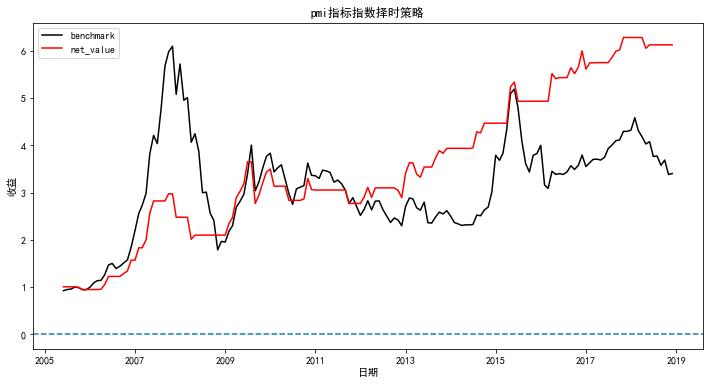

In [262]:
#PMI指标
path_1 = 'C:/wangxiaolei/quant/Rong360-master/hongguan/PMI.xls'
pmi_df = pd.read_excel(path_1,sheetname= [0])[0]
pmi_df.set_index('日期', inplace = True)
#pmi_df.plot(figsize=(15,6),title='PMI')
#获取当前日期过去三个月PMI均值，与上月此时过去三个月PMI均值对比，若是PMI上涨并且本月PMI值大于50则认为本月可以买入指数
pmi_3_mean = pmi_df['PMI'].rolling(window=3).mean()
pmi_3_mean_shift_1 = pmi_3_mean.shift(1)
#pmi_df['position']=((pmi_3_mean > pmi_3_mean_shift_1) * 1) * ((pmi_3_mean.map(lambda x:True if x > 50 else False)) * 1)
pmi_df['position']=(pmi_3_mean > pmi_3_mean_shift_1) * 1
rate_riskfree = 0
hs_df = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')['close']
hs_df_M = hs_df.resample('M',how='last')
hs_df['pct']=hs_df_M.pct_change() #每日收益率
#df_pct['position']=df_boom['position'] #每日收益率
hs_df['net_value'] = (hs_df['pct'] + 1).cumprod()
hs_df['net_value_timing'] = ( hs_df['pct'] * pmi_df['position'] + rate_riskfree * (1-pmi_df['position']) + 1).cumprod()
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
x_index = hs_df_M.index
plt.figure(figsize=(12,6))
plt.plot(x_index, hs_df['net_value'], color='black', label='benchmark')
plt.plot(x_index, hs_df['net_value_timing'], color='red', label='net_value')

plt.axhline(0,ls='--')
plt.title('pmi指标指数择时策略')
plt.xlabel('日期')
plt.ylabel('收益')
#plt.xticks(np.arange(5,26,1),np.arange(5,26,1))
#plt.yticks(np.arange(-1,5,1),np.arange(-1,5,1))
plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


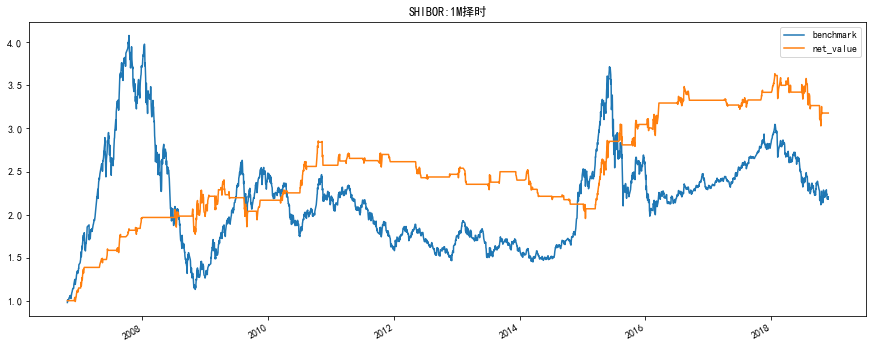

In [266]:
#利率择时
path_rate = path_base + 'SHIBOR.xls'
shibor_df = pd.read_excel(path_rate,sheetname= [0])[0]
#pd.to_datetime(shibor_df['日期'])
shibor_df.set_index('日期', inplace = True)
shibor_df_M = shibor_df.iloc[:,1:2]
#shibor_df_M.plot(figsize=(15,6),title='SHIBOR')
shibor_df_M.columns = ['1M']
upperband,middleband,lowerband = (tl.BBANDS(shibor_df_M['1M'].values, timeperiod=12, nbdevup=1.8, nbdevdn=1.8))
shibor_df_M['BBAND_upper']=upperband
shibor_df_M['BBAND_middle']=middleband
shibor_df_M['BBAND_lower']=lowerband
signal = 0 #中间状态
for date in shibor_df_M.index:
    if shibor_df_M.loc[date,'1M'] > shibor_df_M.loc[date,'BBAND_middle']:
        shibor_df_M.loc[date,'signal'] = 0
    elif shibor_df_M.loc[date,'1M'] < shibor_df_M.loc[date,'BBAND_lower']:
        shibor_df_M.loc[date,'signal'] = 1
    else:
        shibor_df_M.loc[date,'signal'] = signal
    signal = shibor_df_M.loc[date, 'signal']
shibor_df_M['signal']=shibor_df_M['signal'].shift(1)
hs_df = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')
hs_df['pct'] = hs_df.pct_change()
df_pct = pd.concat([hs_df, shibor_df_M],axis=1)
df_pct = pd.concat([df_pct,shibor_df_M],axis=1)['2006-01-01':'2018-11-30'].dropna()
#pd.to_datetime(df_pct.index)
rate_riskfree = 0.0
#df_pct[df_pct.index > dt.datetime.strptime('2006-10-08', '%Y-%m-%d')][df_pct.signal > 0.0]
df_pct['benchmark'] =(df_pct['pct']+1).cumprod()
df_pct['net_value'] = (df_pct['pct'] * shibor_df_M['signal']+ rate_riskfree * (1-shibor_df_M['signal'])+1).cumprod()
df_pct[['benchmark','net_value']].plot(figsize=(15,6),title='SHIBOR:1M择时')

In [267]:
df_pct

,close,pct,1M,BBAND_upper,BBAND_middle,BBAND_lower,signal,1M,BBAND_upper,BBAND_middle,BBAND_lower,signal,benchmark,net_value
2006-10-23,1408.71,-0.021851,2.6166,2.642851,2.594008,2.545166,0.0,2.6166,2.642851,2.594008,2.545166,0.0,0.978149,1.000000
2006-10-24,1440.05,0.022247,2.6165,2.637385,2.601058,2.564732,0.0,2.6165,2.637385,2.601058,2.564732,0.0,0.999910,1.000000
2006-10-25,1446.83,0.004708,2.6163,2.631804,2.606400,2.580996,0.0,2.6163,2.631804,2.606400,2.580996,0.0,1.004617,1.000000
2006-10-26,1456.10,0.006407,2.6164,2.628557,2.609942,2.591326,0.0,2.6164,2.628557,2.609942,2.591326,0.0,1.011054,1.000000
2006-10-27,1439.05,-0.011709,2.6168,2.626216,2.612475,2.598734,0.0,2.6168,2.626216,2.612475,2.598734,0.0,0.999215,1.000000
2006-10-30,1446.24,0.004996,2.6167,2.621120,2.614700,2.608280,0.0,2.6167,2.621120,2.614700,2.608280,0.0,1.004208,1.000000
2006-10-31,1464.47,0.012605,2.6167,2.619011,2.615717,2.612422,0.0,2.6167,2.619011,2.615717,2.612422,0.0,1.016866,1.000000
2006-11-01,1479.41,0.010202,2.6169,2.617971,2.616250,2.614529,0.0,2.6169,2.617971,2.616250,2.614529,0.0,1.027240,1.000000
2006-11-02,1479.66,0.000169,2.6169,2.617065,2.616558,2.616052,0.0,2.6169,2.617065,2.616558,2.616052,0.0,1.027413,1.000000
2006-11-03,1488.29,0.005832,2.6175,2.617258,2.616692,2.616125,0.0,2.6175,2.617258,2.616692,2.616125,0.0,1.033406,1.000000


In [268]:
#获取国债期限利差数据
gz_path = path_base + '/guozhai.xls'
df_gz = pd.read_excel(gz_path, sheet_name= [0])[0]
df_gz.set_index('日期',inplace=True)
df_gz = df_gz.fillna(method='ffill')

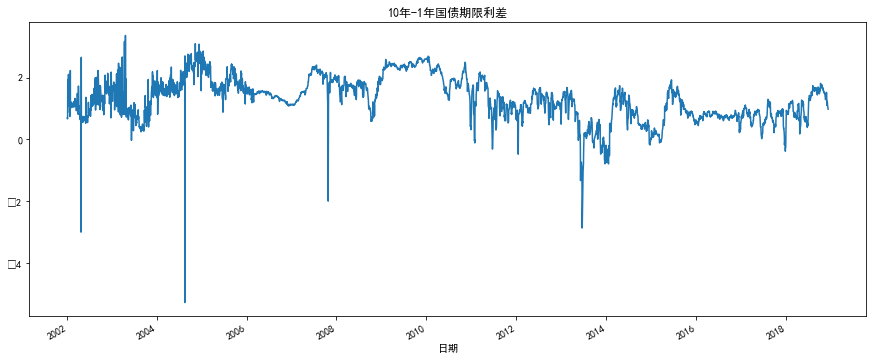

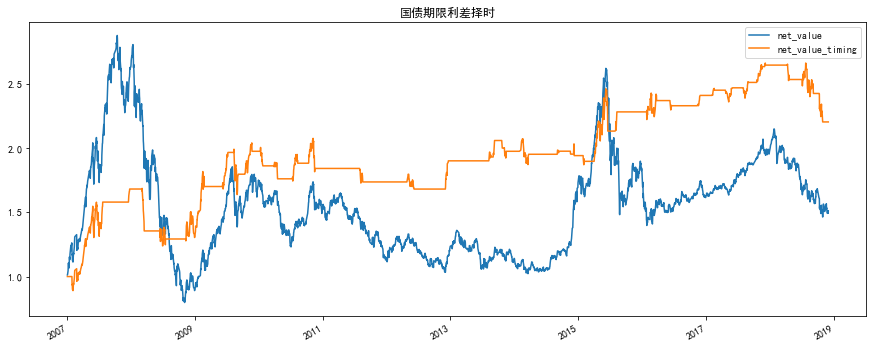

In [269]:
term_spread_gz = df_gz['中债国债到期收益率:10年']-df_gz['中债国债到期收益率:1个月']
#term_spread_gz_diff = term_spread_gz.diff(21)
#term_spread_gz = pd.rolling_mean(term_spread_gz,1)
term_spread_gz.plot(figsize=(15,6),title='10年-1年国债期限利差')
df_gz_spread = pd.DataFrame()
df_gz_spread['term_spread_10_1'] = term_spread_gz
upperband, middleband, lowerband = (tl.BBANDS(df_gz_spread['term_spread_10_1'].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))

df_gz_spread['BBAND_upper'] = upperband
df_gz_spread['BBAND_middle'] = middleband
df_gz_spread['BBAND_lower']=lowerband
signal = 0
for date in df_gz_spread.index:
    if df_gz_spread.loc[date,'term_spread_10_1'] < df_gz_spread.loc[date,'BBAND_middle']:
        df_gz_spread.loc[date,'signal'] = 0
    elif df_gz_spread.loc[date,'term_spread_10_1'] > df_gz_spread.loc[date,'BBAND_upper']:
        df_gz_spread.loc[date,'signal'] = 1.0
    else:
        df_gz_spread.loc[date,'signal'] = signal
    signal = df_gz_spread.loc[date, 'signal']
df_gz_spread['signal']=df_gz_spread['signal'].shift(1)

df_pct = pd.DataFrame()
df_hs = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')
df_hs['pct'] = df_hs['close'].pct_change()

rate_riskfree = 0
df_pct = pd.concat([df_hs, df_gz_spread],axis=1)['2007-01-01':'2018-11-30'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['signal']+rate_riskfree*(1-df_pct['signal'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='国债期限利差择时')

In [278]:
#四、信用利差
path_qyz = path_base +'qiyezhai.xls'
df_qyz = pd.read_excel(path_qyz, sheet_name = [0])[0]
df_qyz.set_index('日期',inplace=True)
df_qyz = df_qyz.fillna(method='ffill')
df_qyz['credit_spread'] = df_qyz['中债企业债到期收益率(AAA):1个月'] - df_gz['中债国债到期收益率:1个月']

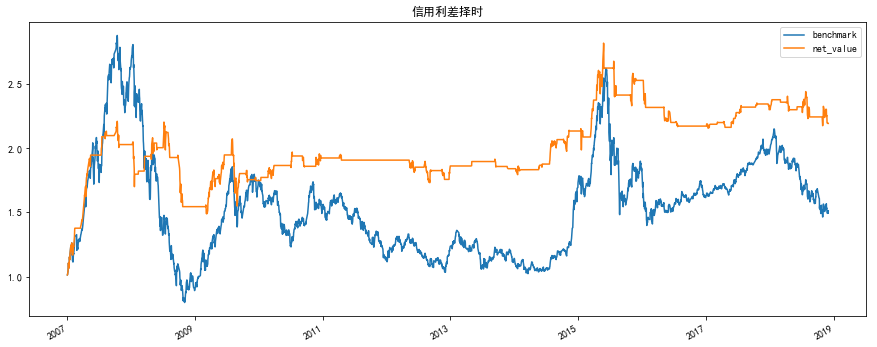

In [279]:
upperband, middleband, lowerband = (tl.BBANDS(df_qyz['credit_spread'].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_qyz['BBAND_upper'] = upperband
df_qyz['BBAND_middle'] =  middleband
df_qyz['BBAND_lower'] = lowerband
signal = 0
for date in df_qyz.index:
    if df_qyz.loc[date,'credit_spread'] > df_qyz.loc[date,'BBAND_middle']:
        df_qyz.loc[date,'signal']=0
    elif df_qyz.loc[date,'credit_spread'] < df_qyz.loc[date,'BBAND_lower']:
        df_qyz.loc[date,'signal']=1.0
    else:
        df_qyz.loc[date,'signal']=signal
    signal=df_qyz.loc[date,'signal']
df_qyz['signal'] = df_qyz['signal'].shift(1)
df_pct=pd.DataFrame()
df_hs = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')
df_hs['pct'] = df_hs['close'].pct_change()
df_pct = pd.DataFrame()
rate_riskfree = 0
df_pct = pd.concat([df_hs, df_qyz],axis=1)['2007-01-01':'2018-11-30'].dropna()
df_pct['benchmark'] = (df_pct['pct']+1).cumprod()
df_pct['net_value'] = (df_pct['pct'] * df_pct['signal'] + rate_riskfree * (1 - df_pct['signal']) + 1).cumprod()
df_pct[['benchmark','net_value']].plot(figsize=(15,6),title='信用利差择时')

In [47]:
#资金流动性
path_xy = path_base + 'xindai.xls'
df_xd = pd.read_excel(path_xy, sheet_name = [0])[0]
df_xd.set_index('日期', inplace = True)
df_xd.fillna(method='ffill', inplace = True)
df_xd['xd_M1-M2'] = df_xd[df_xd.columns[1]] - df_xd[df_xd.columns[2]]
df_xd['xd_M1-M2'] = df_xd['xd_M1-M2'].rolling(3).mean()
df_xd['xd_M1-M2_shift'] = df_xd['xd_M1-M2'].shift(1)
df_xd['signal'] = (df_xd['xd_M1-M2'] > df_xd['xd_M1-M2_shift']) * 1

In [48]:
df_xd = df_xd[df_xd.index > dt.datetime.strptime('2005-04-11', '%Y-%m-%d')]

In [49]:
free_risk_rate = 0.0
df_hs = get_price('000300.XSHG',start_date='2005-04-11',end_date='2018-11-30',fields='close')
df_hs_M = df_hs.resample('M',how='last')
df_hs_M['pct'] = df_hs_M['close'].pct_change()
df_hs_M = df_hs_M.dropna()
df = pd.concat([df_xd, df_hs_M],axis=1)['2005-01-01':'2018-11-30'].dropna()
df['benchmark'] = (df['pct'] + 1).cumprod()
df['net_value'] = (df['pct'] * df['signal'] + free_risk_rate * (1 - df['signal']) + 1).cumprod()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'收益')

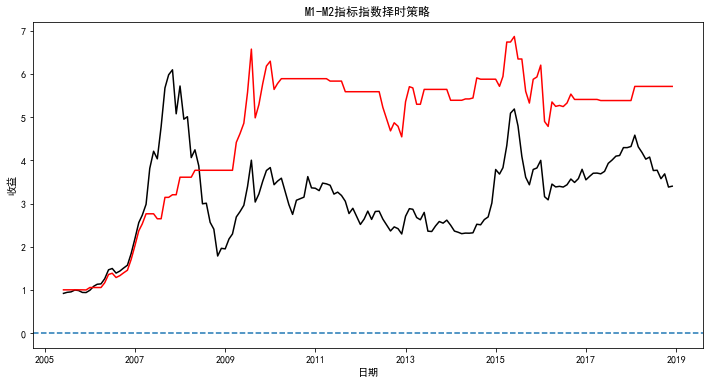

In [50]:
x_index  = df.index
plt.figure(figsize = (12, 6))
plt.plot(x_index, df['benchmark'], color = 'black', label = 'benchamark')
plt.plot(x_index, df['net_value'], color = 'red', label = 'net value')
plt.axhline(0,ls='--')
plt.title('M1-M2指标指数择时策略')
plt.xlabel('日期')
plt.ylabel('收益')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


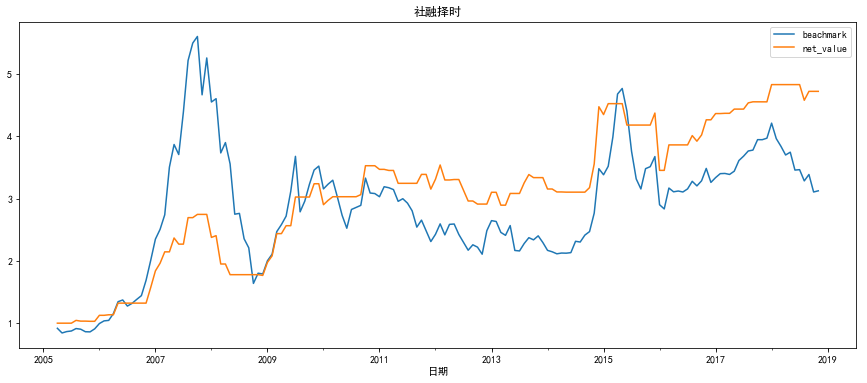

In [208]:
#社融
#资金流动性
path_xy = path_base + 'xindai.xls'
df_xd = pd.read_excel(path_xy, sheet_name = [0])[0]
df_xd.set_index('日期', inplace = True)
df_xd = df_xd[df_xd.index > dt.datetime.strptime('2005-04-11', '%Y-%m-%d')]
df_hs = get_price('000300.XSHG',start_date='2005-04-11',end_date='2018-11-30',fields='close')
df_hs_M = df_hs.resample('M',how='last')
df_hs_M['pct'] = df_hs_M['close'].pct_change().fillna(method = 'bfill')
rate_riskfree = 0.0
df_xd['sr_3_mean'] = df_xd[df_xd.columns[0]].rolling(window=3).mean()
df_xd['sr_3_mean_shift'] = df_xd['sr_3_mean'].shift(1)
df_xd['signal'] = (df_xd['sr_3_mean'] > df_xd['sr_3_mean_shift']) * 1
df_xd['beachmark'] =(df_hs_M['pct'] + 1).cumprod()
df_xd['net_value'] = (df_hs_M['pct'] * df_xd['signal'] + rate_riskfree * (1 - df_xd['signal']) + 1).cumprod()
df_xd[['beachmark','net_value']].plot(figsize=(15,6),title='社融择时')

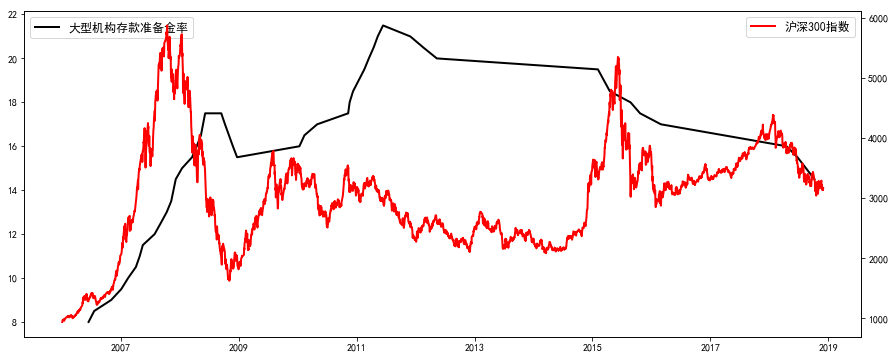

In [172]:
#银行存款准备金，看图形不适合牛市
path_reserve = path_base + 'beifujin.xls'
df_bfj = pd.read_excel(path_reserve, sheet_name = [0])[0]
df_bfj.set_index('日期', inplace = True)
df_bfj = df_bfj[df_bfj.index > dt.datetime.strptime('2006-01-01', '%Y-%m-%d')]
df_bfj = df_bfj[df_bfj.index < dt.datetime.strptime('2018-11-30', '%Y-%m-%d')]
df_bfj.fillna(method = 'ffill', inplace = True)
df_hs = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')
fig = plt.figure(figsize=(15,6))
x_index = df_hs.index
ax1 = fig.add_subplot(111)
ax1.plot(df_bfj[df_bfj.columns[0]],color = 'black', linewidth=2, label='大型机构存款准备金率')
ax1.legend(loc=2,fontsize=12)
ax2=ax1.twinx()#这是双坐标关键一步
ax2.plot(df_hs['close'], color = 'red',linewidth=2,label='沪深300指数')
ax2.legend(loc=1,fontsize=12)
# ax1.grid(False)
ax2.grid(False)
plt.show()

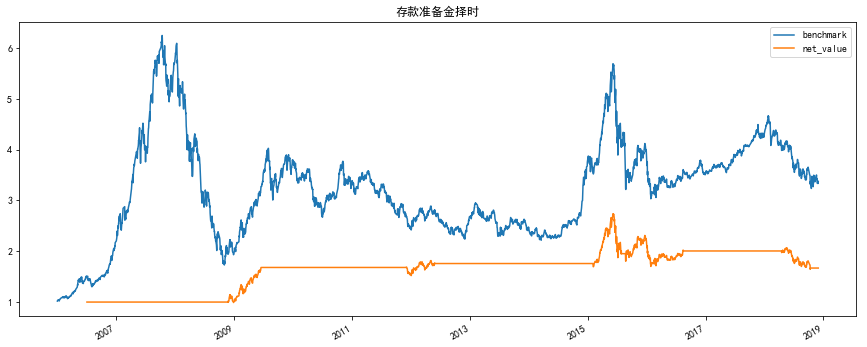

In [190]:
delay_days = 120
signal = 0
for i in range(delay_days,len(df_bfj)):
    pre_index = df_bfj.index[i - delay_days]
    index = df_hs.index[i]
    if df_bfj.loc[index,df_bfj.columns[0]] < df_bfj.loc[pre_index, df_bfj.columns[0]]:
        df_bfj.loc[index,'signal']=1
    elif df_bfj.loc[index, df_bfj.columns[0]] > df_bfj.loc[pre_index, df_bfj.columns[0]]:
        df_bfj.loc[index,'signal']=0.
    else:
        df_bfj.loc[index,'signal']=0.
    signal = df_bfj.loc[index,'signal']
df_bfj = df_bfj.reindex(df_hs.index).fillna(method='ffill')
df_pct = pd.DataFrame()
df_hs['pct'] = df_hs['close'].pct_change()
rate_riskfree = 0
df_pct['benchmark'] =(df_hs['pct']+1).cumprod()
df_pct['net_value'] = (df_hs['pct'] * df_bfj['signal'] + rate_riskfree * (1-df_bfj['signal']) + 1).cumprod()
df_pct[['benchmark','net_value']].plot(figsize=(15,6),title='存款准备金择时')

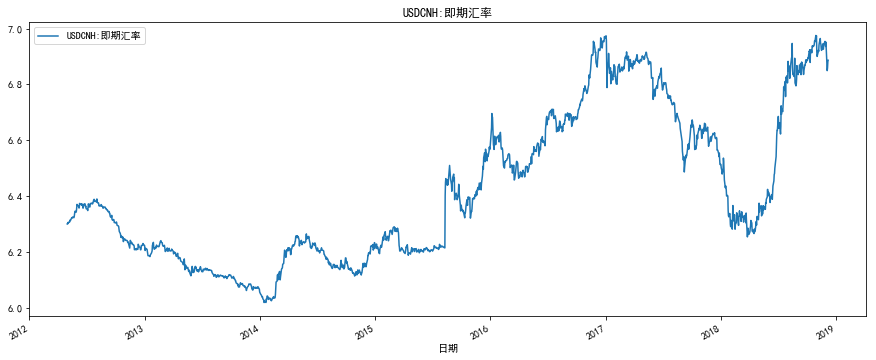

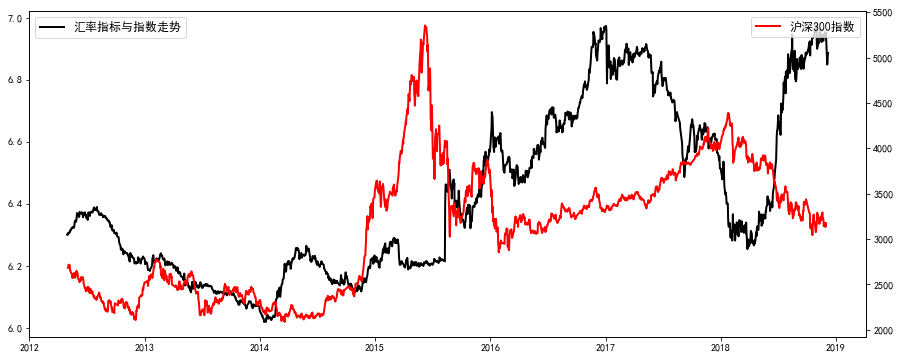

In [55]:
path_hl = path_base + 'huilv.xls'
df_hl = pd.read_excel(path_hl, sheet_name = [0])[0]
df_hl.set_index('日期', inplace = True)
df_hl.plot(figsize=(15,6),title='USDCNH:即期汇率')
df_hs = get_price('000300.XSHG',start_date='2012-04-30',end_date='2018-11-30',fields='close')
fig = plt.figure(figsize=(15,6))
x_index = df_hs.index
ax1 = fig.add_subplot(111)
ax1.plot(df_hl[df_hl.columns[0]],color = 'black', linewidth=2, label='汇率指标与指数走势')
ax1.legend(loc=2,fontsize=12)
ax2=ax1.twinx()#这是双坐标关键一步
ax2.plot(df_hs['close'], color = 'red',linewidth=2,label='沪深300指数')
ax2.legend(loc=1,fontsize=12)
# ax1.grid(False)
ax2.grid(False)
plt.show()

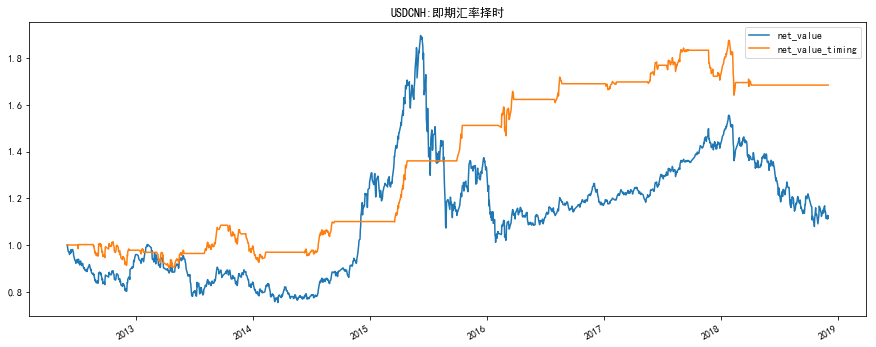

In [254]:
upperband, middleband, lowerband  = (tl.BBANDS(df_hl[df_hl.columns[0]].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_hl['BBAND_upper'] = upperband
df_hl['BBAND_middle'] = middleband
df_hl['BBAND_lower'] = lowerband
signal = 0
for date in df_hl.index:
    if df_hl.loc[date, df_hl.columns[0]] > df_hl.loc[date,'BBAND_middle']:
        df_hl.loc[date,'signal'] = 0
    elif df_hl.loc[date,df_hl.columns[0]] < df_hl.loc[date,'BBAND_lower']:
        df_hl.loc[date,'signal'] = 1.0
    else:
        df_hl.loc[date,'signal'] = signal
    signal=df_hl.loc[date,'signal']
df_hl['signal'] = df_hl['signal'].shift(1)
rate_riskfree = 0
df_pct=pd.DataFrame()
df_hs['pct'] = df_hs['close'].pct_change()
df_pct = pd.concat([df_hs,df_hl],axis=1)['2007-01-01':'2018-11-30'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['signal']+rate_riskfree*(1-df_pct['signal'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='USDCNH:即期汇率择时')

In [318]:
#经济通胀择时，PPI代表企业成本，cpi代表下游企业成本，一般情况下cpi-ppi的差值小的时候会引入宏观调控
#cpi < 0 或者 cpi>5 空仓
path_cpi_ppi= path_base + 'CPI_PPI.xls'
df_cpi_ppi = pd.read_excel(path_cpi_ppi, sheet_name = [0])[0]
df_cpi_ppi.set_index('日期', inplace = True)
df_cpi_ppi = df_cpi_ppi[df_cpi_ppi.index > dt.datetime.strptime('2005-01-31', '%Y-%m-%d')]
df_cpi_ppi = df_cpi_ppi[df_cpi_ppi.index < dt.datetime.strptime('2018-11-30', '%Y-%m-%d')]
df_cpi_ppi['ppi-cci'] = df_cpi_ppi[df_cpi_ppi.columns[2]] - df_cpi_ppi[df_cpi_ppi.columns[0]]
def good_cpi(x):
    if x<0:
        y=0.
    elif x<5.:
        y=1.
    else:
        y=0
    return y
df_cpi_ppi['ppi-cci_mean_3'] = df_cpi_ppi['ppi-cci'].rolling(3).mean()
df_cpi_ppi['ppi-cci_mean_3_shift'] = df_cpi_ppi['ppi-cci_mean_3'].shift(1)
df_cpi_ppi['signal'] = (df_cpi_ppi['ppi-cci_mean_3'] < df_cpi_ppi['ppi-cci_mean_3_shift']) * df_cpi_ppi[df_cpi_ppi.columns[0]].apply(good_cpi)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'收益')

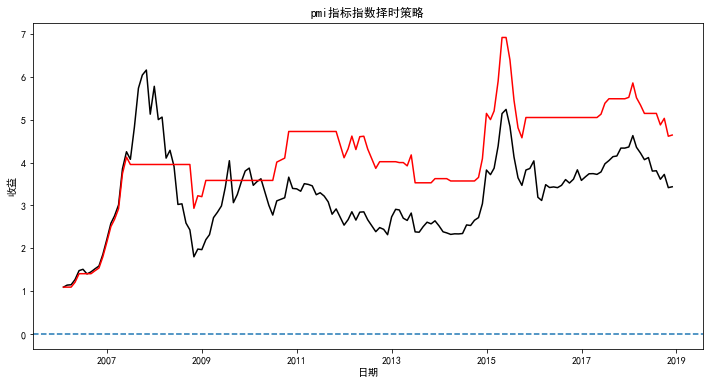

In [319]:
free_risk_rate = 0.0
df_hs = get_price('000300.XSHG',start_date='2005-04-11',end_date='2018-11-30',fields='close')
df_hs_M = df_hs.resample('M',how='last')
df_hs_M['pct'] = df_hs_M['close'].pct_change()
df_hs_M = df_hs_M.dropna()
df = pd.DataFrame()
df = pd.concat([df_cpi_ppi, df_hs_M],axis=1)['2006-01-01':'2018-11-30'].fillna(method='ffill')
df['benchmark'] = (df['pct'] + 1).cumprod()
df['net_value'] = (df['pct'] * df['signal'] + free_risk_rate * (1 - df['signal']) + 1).cumprod()
x_index  = df.index
plt.figure(figsize = (12, 6))
plt.plot(x_index, df['benchmark'], color = 'black', label = 'benchamark')
plt.plot(x_index, df['net_value'], color = 'red', label = 'net value')
plt.axhline(0,ls='--')
plt.title('ppi_cpi指数择时策略')
plt.xlabel('日期')
plt.ylabel('收益')

In [80]:
def show_index_hs(df_index, label):
    df_hs = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')
    fig = plt.figure(figsize=(15,6))
    x_index = df_hs.index
    ax1 = fig.add_subplot(111)
    ax1.plot(df_index,color = 'black', linewidth=2, label=label)
    ax1.legend(loc=2,fontsize=12)
    ax2=ax1.twinx()#这是双坐标关键一步
    ax2.plot(df_hs['close'], color = 'red',linewidth=2,label='沪深300指数')
    ax2.legend(loc=1,fontsize=12)
    # ax1.grid(False)
    ax2.grid(False)
    plt.show()
df_hs = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
df_hs_M = df_hs.resample('M',how='last')
index = pd.date_range(df_hs[df_hs.index[0]], df_hs[df_hs.index[-1]])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  from ipykernel import kernelapp as app


C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


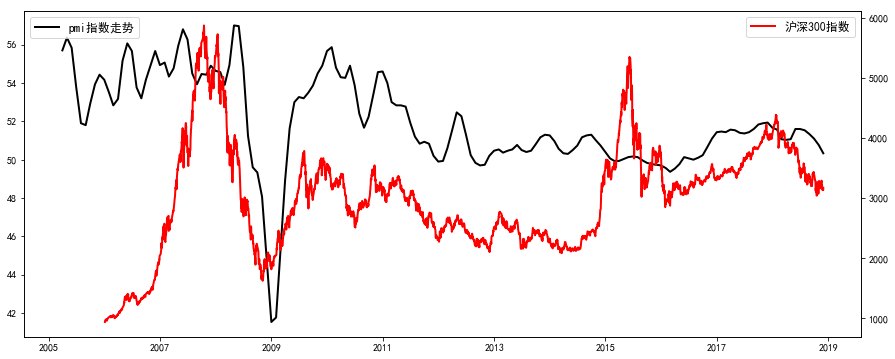

In [176]:
#一、pmi指标
#经理购物指标，指标周期3个月，因为pmi指标并非平滑，以一个季度为粒度并进行平均均值
#pmi信号：3月均线上涨即认为为买入信号
path_1 = 'C:/wangxiaolei/quant/Rong360-master/hongguan/PMI.xls'
pmi_df = pd.read_excel(path_1,sheetname= [0])[0]
pmi_df.set_index('日期', inplace = True)
#pmi_df.plot(figsize=(15,6),title='PMI')
#获取当前日期过去三个月PMI均值，与上月此时过去三个月PMI均值对比，若是PMI上涨并且本月PMI值大于50则认为本月可以买入指数
pmi_df['pmi_3_mean'] = pmi_df['PMI'].rolling(window=3).mean()
pmi_df['pmi_3_mean_shift_1'] = pmi_df['pmi_3_mean'].shift(1)
#pmi_df['position']=((pmi_3_mean > pmi_3_mean_shift_1) * 1) * ((pmi_3_mean.map(lambda x:True if x > 50 else False)) * 1)
pmi_df['signal']=(pmi_df['pmi_3_mean'] > pmi_df['pmi_3_mean_shift_1']) * 1
show_index_hs(pmi_df['pmi_3_mean'], 'pmi指数走势')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


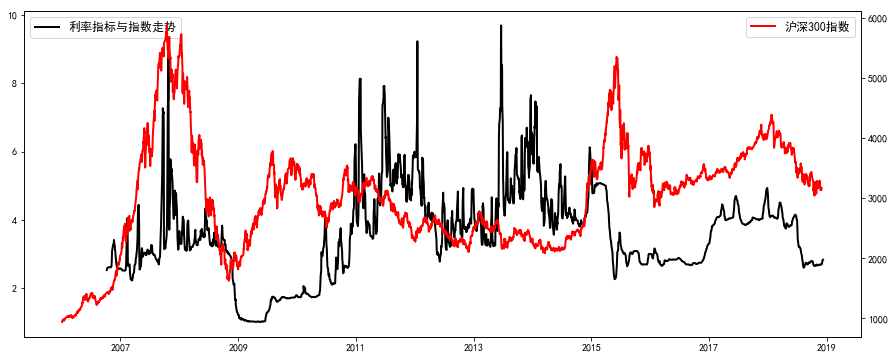

In [212]:
#二、利率指标
#利率择时,低利率买进，高利率卖出，以布尔轨道为依据
path_rate = path_base + 'SHIBOR.xls'
shibor_df = pd.read_excel(path_rate,sheetname= [0])[0]
#pd.to_datetime(shibor_df['日期'])
shibor_df.set_index('日期', inplace = True)
shibor_df_M = shibor_df.iloc[:,1:2]
#shibor_df_M.plot(figsize=(15,6),title='SHIBOR')
show_index_hs(shibor_df[shibor_df.columns[1]], '利率指标与指数走势')

In [213]:
shibor_df_M.columns = ['1M']
upperband, middleband, lowerband = (tl.BBANDS(shibor_df_M['1M'].values, timeperiod=12, nbdevup=1.8, nbdevdn=1.8))
shibor_df_M['BBAND_upper']=upperband
shibor_df_M['BBAND_middle']=middleband
shibor_df_M['BBAND_lower']=lowerband
signal = 0 #中间状态
for date in shibor_df_M.index:
    if shibor_df_M.loc[date,'1M'] > shibor_df_M.loc[date,'BBAND_middle']:
        shibor_df_M.loc[date,'signal'] = 0
    elif shibor_df_M.loc[date,'1M'] < shibor_df_M.loc[date,'BBAND_lower']:
        shibor_df_M.loc[date,'signal'] = 1
    else:
        shibor_df_M.loc[date,'signal'] = signal
    signal = shibor_df_M.loc[date, 'signal']
shibor_df['signal']=shibor_df_M['signal']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


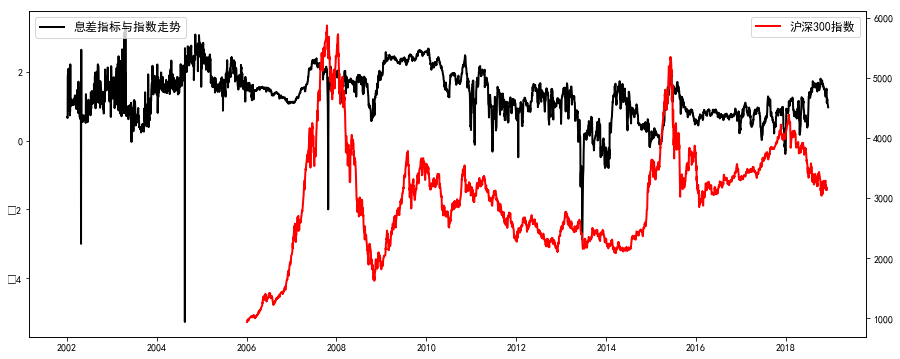

In [179]:
#三、利差指标
#获取国债期限1年期和1月期利差数据，依据布尔通道进行买入卖出
spread_path = path_base + '/guozhai.xls'
df_spread = pd.read_excel(gz_path, sheet_name= [0])[0]
df_spread.set_index('日期',inplace=True)
df_spread = df_gz.fillna(method='ffill')
df_spread['spred_1y_1m'] = df_gz['中债国债到期收益率:10年']-df_gz['中债国债到期收益率:1个月']
show_index_hs(df_spread['spred_1y_1m'], '息差指标与指数走势')

In [180]:
upperband, middleband, lowerband = (tl.BBANDS(df_spread['spred_1y_1m'].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_spread['BBAND_upper'] = upperband
df_spread['BBAND_middle'] = middleband
df_spread['BBAND_lower']=lowerband
signal = 0
for date in df_gz_spread.index:
    if df_spread.loc[date,'spred_1y_1m'] < df_spread.loc[date,'BBAND_middle']:
        df_spread.loc[date,'signal'] = 0
    elif df_spread.loc[date,'spred_1y_1m'] > df_spread.loc[date,'BBAND_upper']:
        df_spread.loc[date,'signal'] = 1.0
    else:
        df_spread.loc[date,'signal'] = signal
    signal = df_spread.loc[date, 'signal']

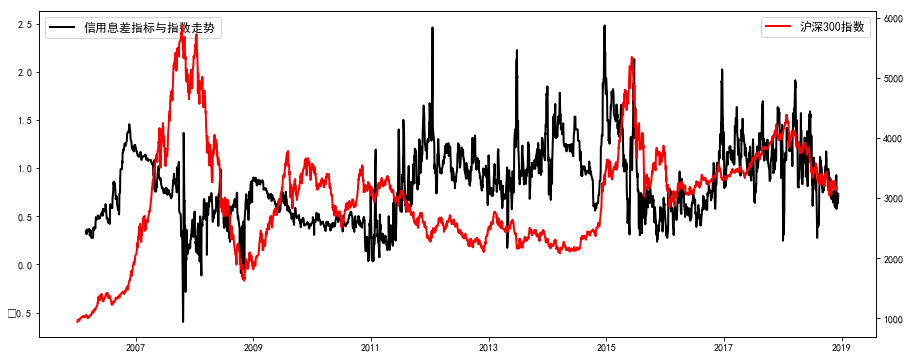

In [222]:
#四、信用利差
#信用利息差越大代表经济形势不好
path_qyz = path_base +'qiyezhai.xls'
df_qyz = pd.read_excel(path_qyz, sheet_name = [0])[0]
df_qyz.set_index('日期',inplace=True)
df_qyz = df_qyz.fillna(method='ffill')
df_qyz['credit_spread'] = df_qyz['中债企业债到期收益率(AAA):1个月'] - df_spread['中债国债到期收益率:1个月']
show_index_hs(df_qyz['credit_spread'], '信用息差指标与指数走势')

In [223]:
upperband, middleband, lowerband = (tl.BBANDS(df_qyz['credit_spread'].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_qyz['BBAND_upper'] = upperband
df_qyz['BBAND_middle'] =  middleband
df_qyz['BBAND_lower'] = lowerband
signal = 0
for date in df_qyz.index:
    if df_qyz.loc[date,'credit_spread'] > df_qyz.loc[date,'BBAND_middle']:
        df_qyz.loc[date,'signal']=0
    elif df_qyz.loc[date,'credit_spread'] < df_qyz.loc[date,'BBAND_lower']:
        df_qyz.loc[date,'signal']=1.0
    else:
        df_qyz.loc[date,'signal']=signal
    signal=df_qyz.loc[date,'signal']

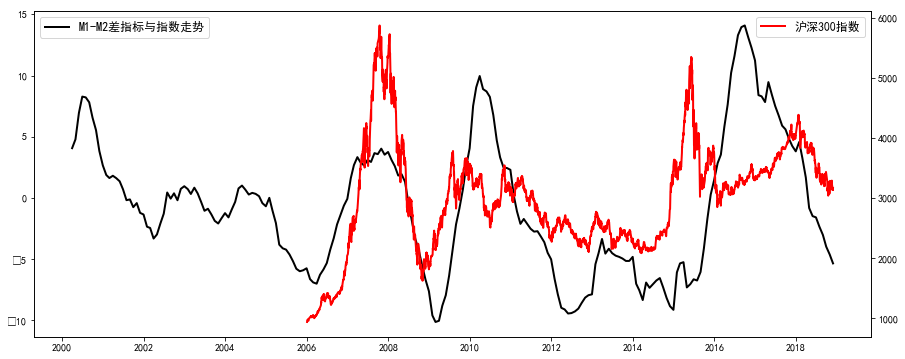

In [239]:
#五、货币流动性
#采用企业定期存款的资金变动表征股市资金是否流动性充足
path_xy = path_base + 'xindai.xls'
df_xd = pd.read_excel(path_xy, sheet_name = [0])[0]
df_xd.set_index('日期', inplace = True)
df_xd.fillna(method='ffill', inplace = True)
df_xd['xd_M1-M2'] = df_xd[df_xd.columns[1]] - df_xd[df_xd.columns[2]]
df_xd['xd_M1-M2'] = df_xd['xd_M1-M2'].rolling(3).mean()
show_index_hs(df_xd['xd_M1-M2'], 'M1-M2差指标与指数走势')

In [240]:
df_xd['xd_M1-M2_shift'] = df_xd['xd_M1-M2'].shift(1)
df_xd['signal'] = (df_xd['xd_M1-M2'] > df_xd['xd_M1-M2_shift']) * 1

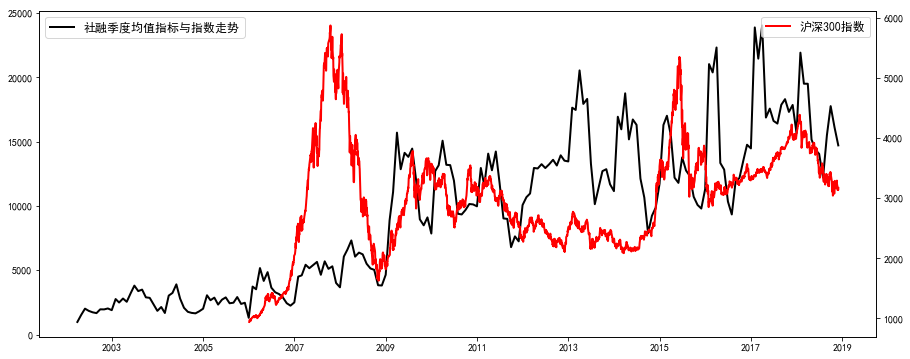

In [243]:
#六 社融
#社融增加则代表经济向好
df_xd['sr_3_mean'] = df_xd[df_xd.columns[0]].rolling(window=3).mean()
show_index_hs(df_xd['sr_3_mean'], '社融季度均值指标与指数走势')
df_xd['sr_3_mean_shift'] = df_xd['sr_3_mean'].shift(1)
df_xd['sr_signal'] = (df_xd['sr_3_mean'] > df_xd['sr_3_mean_shift']) * 1

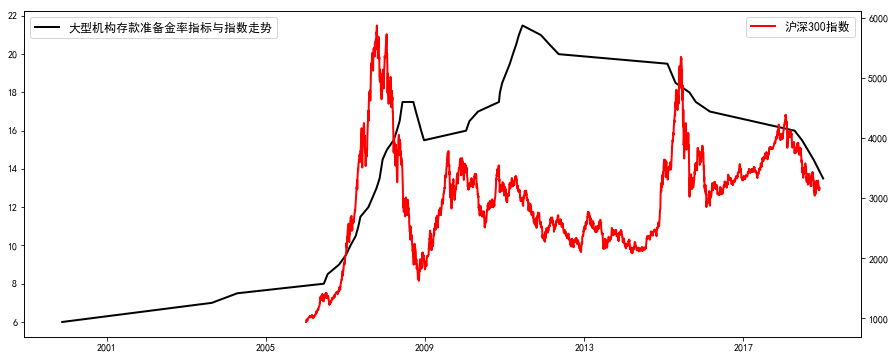

In [228]:
#七、银行准备金
#降准利好股市
path_reserve = path_base + 'beifujin.xls'
df_bfj = pd.read_excel(path_reserve, sheet_name = [0])[0]
df_bfj['日期']=pd.to_datetime(df_bfj['日期'],format='%Y-%m-%d')
df_bfj.set_index('日期', inplace = True)
show_index_hs(df_bfj[df_bfj.columns[0]], '大型机构存款准备金率指标与指数走势')

In [229]:
df_hs = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')
df_hs.index = pd.to_datetime(df_hs.index,format='%Y-%m-%d')
index = pd.date_range(df_bfj.index[0], df_bfj.index[-1])
df_bfj =  df_bfj.reindex(index).fillna(method='ffill')
df_bfj = df_bfj.reindex(df_hs.index).fillna(method='ffill')
delay_days = 120 #以120日为频率作为降准抽样
signal = 0

for i in range(delay_days,len(df_bfj)):
    pre_date = df_bfj.index[i - delay_days]
    date = df_bfj.index[i]   
    if df_bfj.loc[date,df_bfj.columns[0]] < df_bfj.loc[pre_date, df_bfj.columns[0]]:
        df_bfj.loc[date,'signal']=1
    elif df_bfj.loc[date, df_bfj.columns[0]] > df_bfj.loc[pre_date, df_bfj.columns[0]]:
        df_bfj.loc[date,'signal']=0.0
    else:
        df_bfj.loc[date,'signal']= 0
    signal = df_bfj.loc[date,'signal']
df_bfj.fillna(0.0)
df_bfj['signal'] = df_bfj['signal']

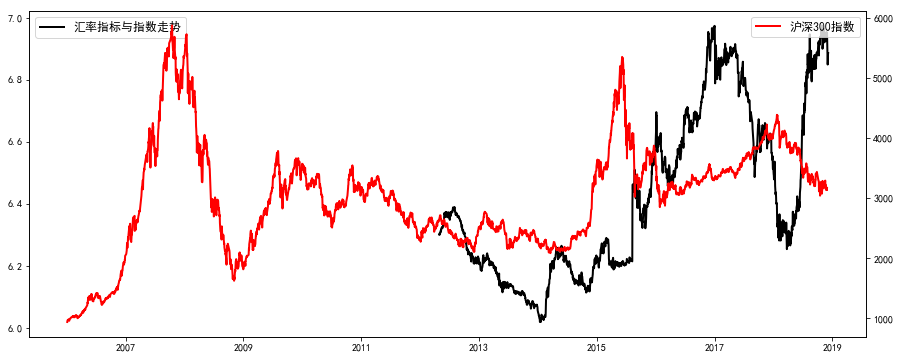

In [230]:
#八、汇率
#新型市场与发达市场的汇率指标是反作用
path_hl = path_base + 'huilv.xls'
df_hl = pd.read_excel(path_hl, sheet_name = [0])[0]
df_hl.set_index('日期', inplace = True)
show_index_hs(df_hl[df_hl.columns[0]], '汇率指标与指数走势')

In [231]:
upperband, middleband, lowerband  = (tl.BBANDS(df_hl[df_hl.columns[0]].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_hl['BBAND_upper'] = upperband
df_hl['BBAND_middle'] = middleband
df_hl['BBAND_lower'] = lowerband
signal = 0
for date in df_hl.index:
    if df_hl.loc[date, df_hl.columns[0]] > df_hl.loc[date,'BBAND_middle']:
        df_hl.loc[date,'signal'] = 0
    elif df_hl.loc[date,df_hl.columns[0]] < df_hl.loc[date,'BBAND_lower']:
        df_hl.loc[date,'signal'] = 1.0
    else:
        df_hl.loc[date,'signal'] = signal
    signal=df_hl.loc[date,'signal']
df_hl['signal'] = df_hl['signal']

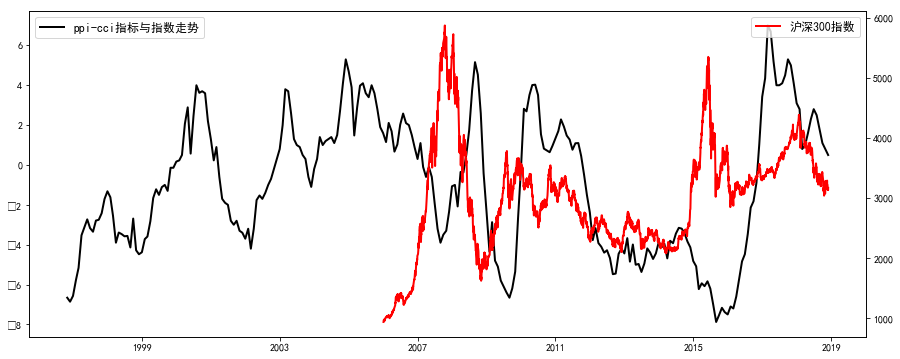

In [232]:
#九、通胀指标，cpi、ppi
#经济通胀择时，PPI代表企业成本，cpi代表下游企业成本，一般情况下cpi-ppi的差值小的时候会引入宏观调控
#cpi < 0 或者 cpi>5 空仓
path_cpi_ppi= path_base + 'CPI_PPI.xls'
df_cpi_ppi = pd.read_excel(path_cpi_ppi, sheet_name = [0])[0]
df_cpi_ppi.set_index('日期', inplace = True)
df_cpi_ppi['ppi-cci'] = df_cpi_ppi[df_cpi_ppi.columns[2]] - df_cpi_ppi[df_cpi_ppi.columns[0]]
show_index_hs(df_cpi_ppi['ppi-cci'], 'ppi-cci指标与指数走势')

In [233]:
def good_cpi(x):
    if x<0:
        y=0.
    elif x<5.:
        y=1.
    else:
        y=0
    return y
df_cpi_ppi['ppi-cci_mean_3'] = df_cpi_ppi['ppi-cci'].rolling(3).mean()
df_cpi_ppi['ppi-cci_mean_3_shift'] = df_cpi_ppi['ppi-cci_mean_3'].shift(1)
df_cpi_ppi['signal'] = (df_cpi_ppi['ppi-cci_mean_3'] < df_cpi_ppi['ppi-cci_mean_3_shift']) * df_cpi_ppi[df_cpi_ppi.columns[0]].apply(good_cpi)

In [220]:
#汇总以上宏观指标
df_hs = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')
df_hs.index = pd.to_datetime(df_hs.index,format='%Y-%m-%d')
index = pd.date_range(df_bfj.index[0], df_bfj.index[-1])
#利率
pmi_M_signal = pmi_df['signal'].reindex(index).fillna(method='ffill').reindex(df_hs_M.index).shift(1).fillna(0.0) * 1
#利息差
shibor_spread_M_signal = shibor_df['signal'].reindex(index).fillna(method='ffill').reindex(df_hs_M.index).shift(1).fillna(0.0) * 1
#信用利息差
credit_spread_M_signal = df_spread['signal'].reindex(index).fillna(method='ffill').reindex(df_hs_M.index).shift(1).fillna(0.0) * 1
#利息指标汇总加权
df_interest_rate_signal = ((pmi_M_signal * 1 + shibor_spread_M_signal * 1 + credit_spread_M_signal * 1) / 3.) * 1

In [253]:
#汇率
df_forex = df_hl['signal'].reindex(index).fillna(method='ffill').reindex(df_hs_M.index) * 1
#融资情况
df_credit = ((df_xd['signal'].reindex(df_hs_M.index) * 1 + df_xd['sr_signal'].reindex(df_hs_M.index) * 1) / 2.)*1

In [257]:
df_month = pd.concat([df_interest_rate_signal, df_forex.shift(1).fillna(0.0), df_credit.shift(1).fillna(0.0),\
                  pmi_df['signal'].shift(1).fillna(0.0), df_cpi_ppi['signal'].shift(1).fillna(0.0)],axis=1).reindex(df_hs_M.index)
df_month.columns = ['monetary','forex','credit','boom','inflation']#货币政策，汇率，信贷，经济增长，通货膨胀
df_month

,monetary,forex,credit,boom,inflation
2006-01-31,0.000000,0.0,0.0,0.0,1.0
2006-02-28,0.000000,0.0,0.5,0.0,1.0
2006-03-31,0.000000,0.0,0.0,0.0,0.0
2006-04-30,0.333333,0.0,0.5,1.0,0.0
2006-05-31,0.333333,0.0,0.5,1.0,1.0
2006-06-30,0.333333,0.0,1.0,1.0,1.0
2006-07-31,0.000000,0.0,0.5,0.0,0.0
2006-08-31,0.000000,0.0,0.5,0.0,0.0
2006-09-30,0.333333,0.0,0.5,0.0,0.0
2006-10-31,0.333333,0.0,0.5,1.0,1.0


In [259]:
weight_f=([1,1,1,1,1]) #五大类指标权重
timing_count = ((df_month[df_month.columns] >= 0) * weight_f).sum(axis=1)
df_month['tot_pos'] = ((df_month[df_month.columns]*weight_f).sum(axis=1)/timing_count>0.55)*0.5+\
    ((df_month[df_month.columns]*weight_f).sum(axis=1)/timing_count>0.45)*0.5

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


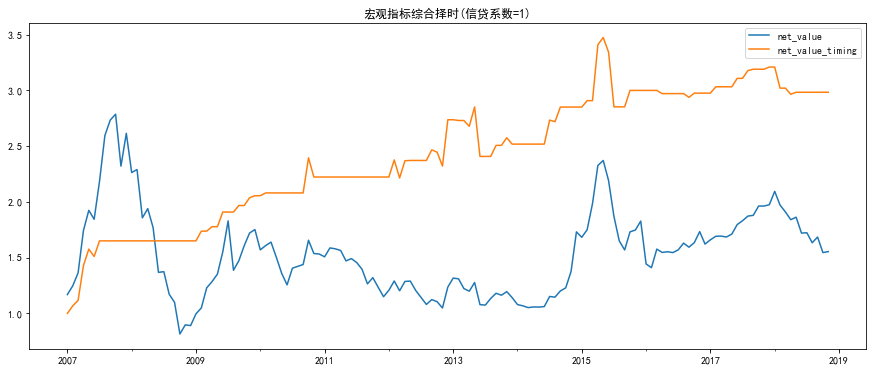

In [260]:
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0
df_pct=pd.DataFrame()
start_date='2007-01-01'
df_pct['pct']=prices_M.pct_change()[start_date:]
df_pct['position']=df_month['tot_pos']
df_pct['net_value'] =(df_pct['pct']+1)[start_date:].cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1)[start_date:].cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='宏观指标综合择时(信贷系数=1)')